In [1]:
import sys
import os
import torch
import numpy as np
import shutil

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms
from PIL import Image
from PIL import ImageFile
from torchvision.datasets import ImageFolder

sys.path.insert(0, '..')
from data import crop_upper_part
from model import SqueezeModelSoftmax

from sklearn.metrics import classification_report
import pickle

import matplotlib.pyplot as plt

%matplotlib inline

import pdb

In [33]:
# path to a PyTorch state dict
MODEL_PATH = '../models/26-more-aug_epoch_21-valLoss_0.01981-valF1_0.99838' 
NUM_CLASSES = 26
INPUT_SHAPE = (3, 370, 400) # C x H x W
BATCH_SIZE = 64

# path to a non-annotated dataset where all images are in same folder with name: <integer_id>.jpg
DATASET_PATH = '/media/bartol/Ostalo/mozgalo_dataset_backup/mozgalo_split/train'

NUM_THREADS = 8 # number of threads to use - should be same as number of virtual CPU cores
USE_GPU = True # use CUDA related stuff

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
class_labels = {
 'Albertsons': 0,
 'BJs': 1,
 'CVSPharmacy': 2,
 'Costco': 3,
 'FredMeyer': 4,
 'Frys': 5,
 'HEB': 6,
 'HarrisTeeter': 7,
 'HyVee': 8,
 'JewelOsco': 9,
 'KingSoopers': 10,
 'Kroger': 11,
 'Meijer': 12,
 'Other': 13,
 'Publix': 14,
 'Safeway': 15,
 'SamsClub': 16,
 'ShopRite': 17,
 'Smiths': 18,
 'StopShop': 19,
 'Target': 20,
 'Walgreens': 21,
 'Walmart': 22,
 'Wegmans': 23,
 'WholeFoodsMarket': 24,
 'WinCoFoods': 25}

class_dict = {v: k for k, v in class_labels.items()}

In [8]:
def data_preprocess_transformations(input_shape, crop_perc = 0.5):
    """Preprocess object for transforming image to model input
    Args:
        input_shape: model input shape (channels x height x width)
        crop_perc: percent of how much image would be cropped from

    Returns:
        Composite of transforms objects.
    """
    
    num_channels, height, width = input_shape
    
    return transforms.Compose([
        transforms.Lambda(lambda x: crop_upper_part(np.array(x), crop_perc)),
        transforms.ToPILImage(),
        transforms.Grayscale(num_channels),
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

In [34]:
val_transform = data_preprocess_transformations(INPUT_SHAPE, crop_perc=0.5)
validation_dataset = ImageFolder(root=DATASET_PATH,                                                  
                                      transform=val_transform)                                                                           
    
validation_dataset_loader = DataLoader(validation_dataset,                                                                          
                                            batch_size=BATCH_SIZE,                                                                  
                                            shuffle=False,                                                                               
                                            num_workers=NUM_THREADS)                                                             
                                

In [35]:
# Load model
model = SqueezeModelSoftmax(num_classes=NUM_CLASSES)
model_state_dict = torch.load(MODEL_PATH, map_location=lambda storage, loc: storage)
model.load_state_dict(model_state_dict)
model.eval()
torch.set_num_threads(NUM_THREADS)

if USE_GPU:
    model.cuda(0)

In [36]:
def var(tensor):
    if USE_GPU:
        tensor = tensor.cuda(0)
    return tensor

# Run prediction
predictions, gts = [], []
num_batches = len(validation_dataset_loader)

for batch_index, (test_batch, ground_truth) in enumerate(validation_dataset_loader):
    batch_input_tensors = var(test_batch)

    batch_predictions = model(batch_input_tensors).cpu().data.numpy()
    predictions.extend(batch_predictions)
    gts.extend(ground_truth.cpu().data.numpy())
    
    print('Batch {}/{}'.format(batch_index + 1, num_batches), end="\r", flush=True)

predictions = np.array(predictions)

In [37]:
print(classification_report(gts, np.argmax(predictions, 1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      1899
          1       1.00      1.00      1.00      1766
          2       1.00      1.00      1.00      2225
          3       1.00      1.00      1.00      2059
          4       1.00      1.00      1.00      2086
          5       1.00      1.00      1.00      2001
          6       1.00      1.00      1.00      2125
          7       1.00      1.00      1.00      1814
          8       1.00      1.00      1.00      1705
          9       1.00      1.00      1.00      2205
         10       1.00      1.00      1.00      1819
         11       1.00      1.00      1.00      1716
         12       1.00      1.00      1.00      2106
         13       1.00      1.00      1.00     47612
         14       1.00      1.00      1.00      2142
         15       1.00      1.00      1.00      2072
         16       1.00      1.00      1.00      1837
         17       1.00      1.00      1.00   

In [38]:
# Extract per class max activations
act_dict = {key: [] for key in class_labels.keys()}

for act, gt in zip(predictions, gts):
    pred = np.argmax(act)
    if pred == gt:
        act_dict[class_dict[pred]].append(np.max(act)) 

In [45]:
THR_FILE = "../models/thresholds_all_data.pkl"
thr_dict = dict()
for k, act in act_dict.items():
    act = np.array(act)
    # Remove outliers
    #act = act[act > 1 - np.std(act) * 4]
    
    print("{}: Mean {:.5f}, std {:.5f}".format(k, np.mean(act), np.std(act)))
    thr_dict[k] = 1 - 10 * np.std(act)

with open(THR_FILE, "wb") as f:
    pickle.dump(thr_dict, f)

Kroger: Mean 0.99814, std 0.01994
Frys: Mean 0.99817, std 0.01904
KingSoopers: Mean 0.99937, std 0.00647
Target: Mean 0.99852, std 0.01300
HarrisTeeter: Mean 0.99769, std 0.02569
Smiths: Mean 0.99918, std 0.00379
Costco: Mean 0.99933, std 0.01080
SamsClub: Mean 0.99937, std 0.00765
Albertsons: Mean 0.99855, std 0.01074
StopShop: Mean 0.99853, std 0.01422
JewelOsco: Mean 0.99813, std 0.01685
CVSPharmacy: Mean 0.99883, std 0.01583
ShopRite: Mean 0.99846, std 0.01420
Other: Mean 0.99615, std 0.02363
HyVee: Mean 0.99840, std 0.01432
Publix: Mean 0.99884, std 0.01317
Wegmans: Mean 0.99908, std 0.00438
HEB: Mean 0.99974, std 0.00144
Walgreens: Mean 0.99851, std 0.01886
Meijer: Mean 0.99905, std 0.00647
WholeFoodsMarket: Mean 0.99839, std 0.01044
Safeway: Mean 0.99946, std 0.00363
FredMeyer: Mean 0.99968, std 0.00395
WinCoFoods: Mean 0.99896, std 0.00788
Walmart: Mean 0.99865, std 0.01516
BJs: Mean 0.99946, std 0.00537


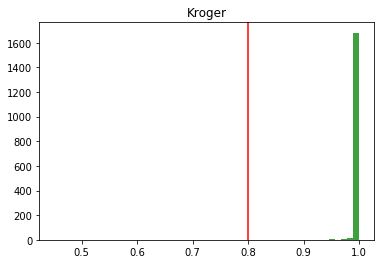

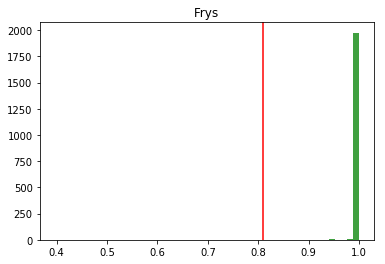

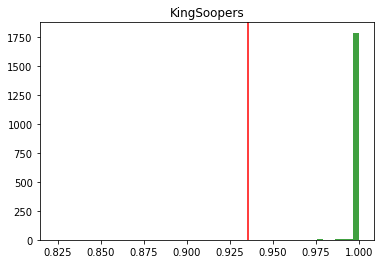

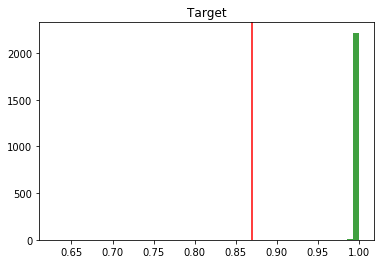

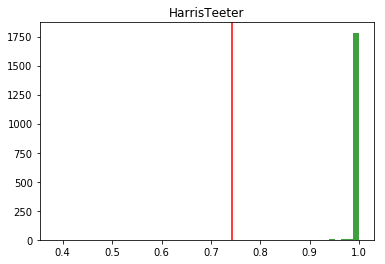

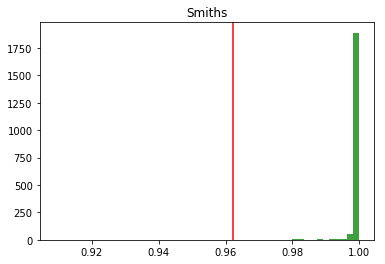

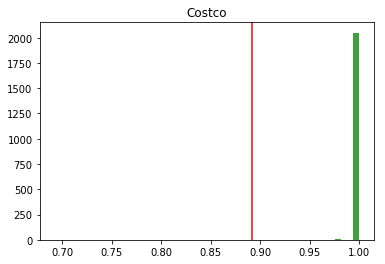

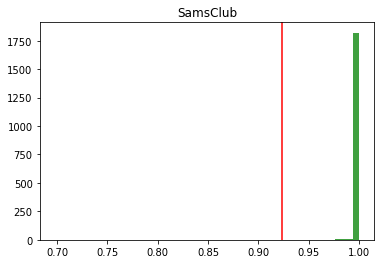

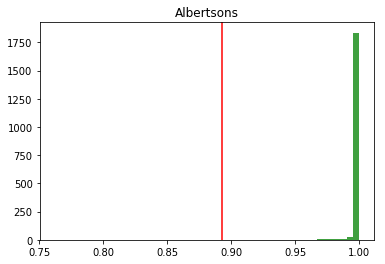

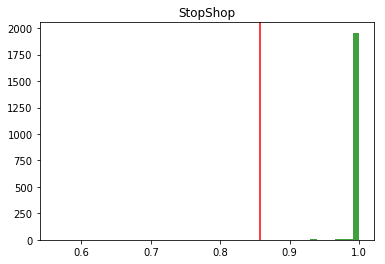

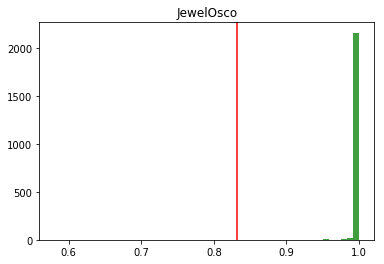

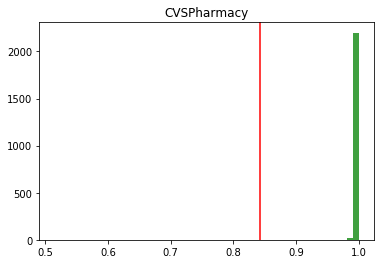

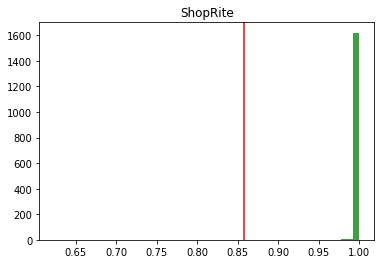

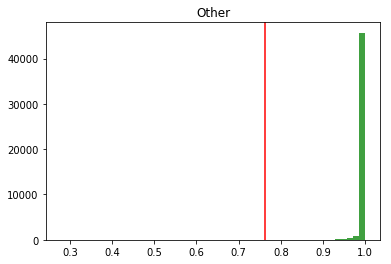

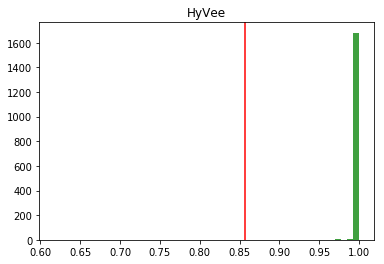

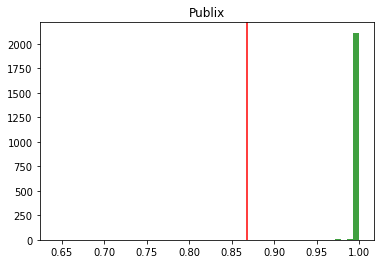

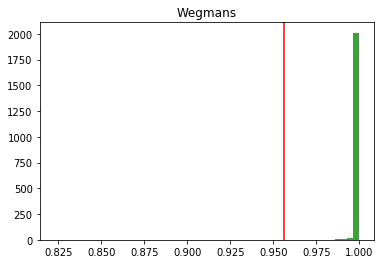

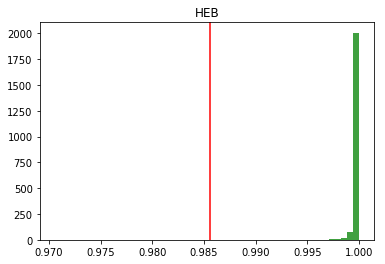

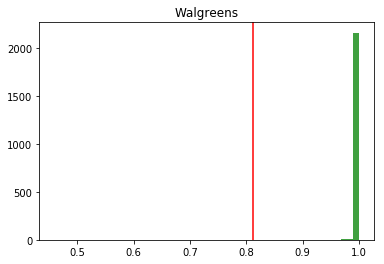

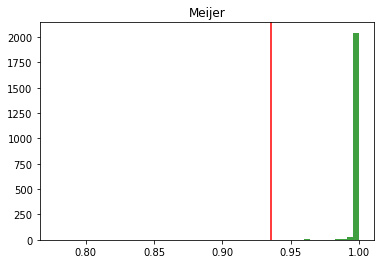

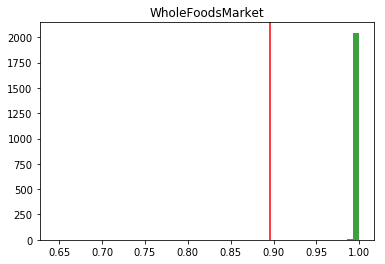

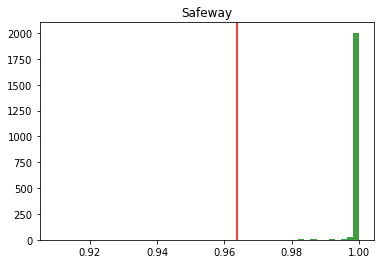

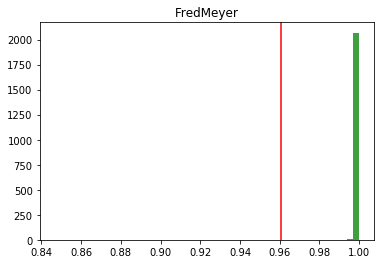

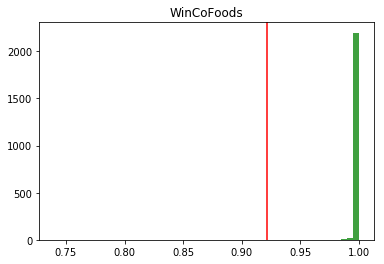

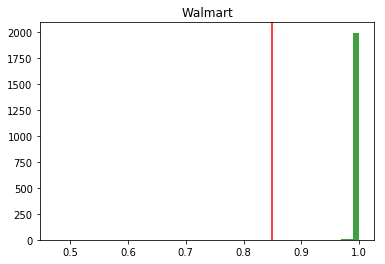

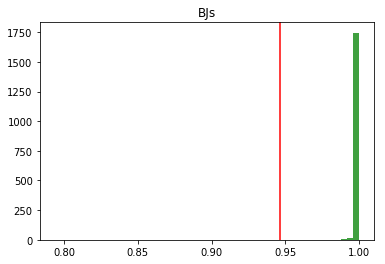

In [46]:
### Plot activation histogram

for k, v in act_dict.items():
    x = list(filter(lambda x: x > 0.2, v))

    plt.hist(x, 50, facecolor='green', alpha=0.75)
    plt.axvline(thr_dict[k], color="red")
    plt.title(k)
    plt.show()